# 使用手寫辨識資料集, 觀察 PCA 算法

# [作業目標]
- 試著模仿範例寫法, 以變更參數後的 PCA + 邏輯斯迴歸判斷手寫辨識資料集, 觀察不同 component 下正確率的變化

# [作業重點]
- 以手寫辨識資料集, 觀察變更參數後的 PCA 算法, 在取不同 component 時, PCA 解釋度與分類正確率如何變化 (In[5], Out[5])

In [0]:
# 載入套件
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [0]:
# 定義 PCA 與隨後的羅吉斯迴歸函數
# penalty 改為 L1, max_iter 改為 100
logistic = SGDClassifier(loss='log', penalty='l1', max_iter=100, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# 載入手寫數字辨識集
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

# 作業
* 將參數 penalty 改為 L1, max_iter 改為 100, 觀察 PCA 與羅吉斯迴歸做手寫辨識的效果

In [4]:
# 先執行 GridSearchCV 跑出最佳參數
param_grid = {
    'pca__n_components': [10, 15, 20, 30, 40, 50, 64],
    # https://blog.csdn.net/shenpengjianke/article/details/29356755
    'logistic__alpha': np.logspace(-4, 4, 10),
}

search = GridSearchCV(pipe , param_grid, iid=False, cv=5, return_train_score=False)
search.fit(X_digits , y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.910):
{'logistic__alpha': 0.005994842503189409, 'pca__n_components': 20}


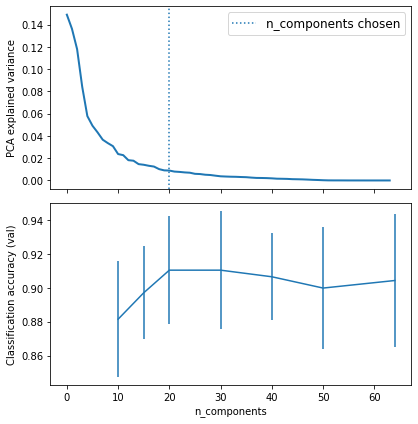

In [5]:
# 繪製不同 components 的 PCA 解釋度
pca.fit(X_digits)

# Controls sharing of properties among x
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
# explained_variance_ratio_:The amount of variance explained by each of the selected components
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

# n_components:The estimated number of components.
ax0.axvline(search.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen')
# prop代表property
ax0.legend(prop=dict(size=12))

# 繪製不同採樣點的分類正確率
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
# Return the first n rows ordered by columns in descending order.
best_clfs = results.groupby(components_col).apply(lambda g: g.nlargest(1, 'mean_test_score'))

# https://blog.csdn.net/brucewong0516/article/details/80524442
best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score', legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')
plt.tight_layout()
plt.show()